# Electrode selecting

This notebook demonstrates a simple version of an electrode-selecting method defined in `chmap.probe_npx.select_weaker:electrode_select`, which is a [Neuropixels probe](https://www.neuropixels.org/) electrode-selecting method with a weaker arrangement rule.

## Terms

* `ChannelMap`: Neuropixels probe channel arrangement configuration (channel map).
* `ProbeDesp`: an interface for communicating between the chanelmap `ChannelMap` and the GUI.
* `ElectrodeDesp`: an interface for communicating between the electrode and the GUI, which contains policy value.
* **policy**: indicates how an electrode is selected. In here, we have density-based policies.
* **blueprint**: all electrode policies value (a collection). It decides how a channel map outcome.
* **hardware restriction rule**: a predicate representing whether electrodes can be selected together. Defined in `NpxProbeDesp.probe_rule`
* **arrangement rule**: a rule indicates how electrodes inside an area are selected to form a particular arrangement pattern by a given policy.
* **priority**: each electrode has a priority value depended on its policy value. It decides the priority of being selected.

## Demostration

In [ ]:
M = ChannelMap
K = tuple[int, int, int] # (shank, column, row)

class E(ElectrodeDesp):
    electrode: K
    channel: int
    policy: str
    prob: float # probability, but work as a priority here

def electrode_select(desp: ProbeDesp[M, E], chmap: M, blueprint: list[E], **kwargs) -> ChannelMap:
    """
    Selecting electrodes based on the electrode blueprint.

    :param desp:
    :param chmap: channelmap type. It is a reference.
    :param blueprint: channelmap blueprint
    :param kwargs: other parameters.
    :return: generated channelmap
    """
    step_1(...) # work as inlined function here
    step_2(...) # work as inlined function here
    step_loop(...) # work as inlined function here
    return build_channelmap()

### Step 1: Initialization

Put all possible electrodes into the candidate set `cand`. Initialize a priority value for all electrodes depending on their  policy.


In [ ]:
def step_1(desp: ProbeDesp[M, E], chmap: M, blueprint: list[E]):
    # initialize a cancidate set
    cand: dict[K, E] = {
        it.electrode: E().copy(it, prob=0) for it in desp.all_electrodes(chmap)
    }
    # pass policy value
    for e in blueprint:
        cand[e.electrode].policy = e.policy
    # initialize priority value
    for e in cand.values():
        e.prob = policy_mapping_priority(e.policy)

Here `policy_mapping_priority` defined as

In [ ]:
def policy_mapping_priority(policy: str) -> float:
    match policy:
        case 'pre-selected':
            return 1.0
        case 'full-density':
            return 0.9
        case 'half-density':
            return 0.8
        case 'quarter-density':
            return 0.7
        case 'remainder':
            return 0.6
        case 'forbidden':
            return 0
        case _:
            return 0.5

### Step 2: Pre-Selection

Make the priority value of `pre-selected` electrodes to 1, and `forbidden` electrodes to 0, as well as all electrodes that against the hardware restriction rule.


In [ ]:
def step_2(desp: ProbeDesp[M, E], cand: dict[K, E]):
    for e in cand.values():
        if e.policy == 'pre-selected':
            _add(desp, cand, e)

where a helper function `_add` defined as

In [ ]:
def _add(desp: ProbeDesp[M, E], cand: dict[K, E], e: E):
    e.prob = 1.0

    for k in cand.values():
        if e.electrode != k.electrode and not desp.probe_rule(None, e, k):
            k.prob = 0

### Step Loop: 

Start from this step, we enter a selecting loop.

In [ ]:
def step_loop(desp: ProbeDesp[M, E], chmap:M, cand: dict[K, E]):
    while selected_electrode(cand) < chmap.n_channels:
        if (e := pick_electrode(cand)) is not None:
            # step 4
            select_electrode(desp, cand, e)
            # step 5
            update_prob(desp, cand, e)
        else:
            break

where `selected_electrode` used as a terminated condiction.

In [ ]:
def selected_electrode(cond: dict[K, E]) -> int:
    # selected electrode is defined as it.prob == 1
    return len([it for it in cond.values() if it.prob == 1])

### Step 3: Select electrode

Randomly select an electrode with the highest priority value from the candidate set

In [ ]:
import random

def pick_electrode(cand: dict[K, E]) -> E | None:
    hp = max([it.prob for it in cand.values() if it.prob < 1])

    if hp == 0: # all un-selected electrode are forbidden
        return None

    sub = [it for it in cand.values() if hp <= it.prob < 1]
    assert len(sub) > 0
    return random.choice(sub)

### step 4: Add to channel map & Apply Hardware Rule

Set the priority of the selected electrode to 1, and set the priority of electrodes against the hardware restriction rule with the selected electrode to 0.


In [ ]:
def select_electrode(desp: ProbeDesp[M, E], cand: dict[K, E], e: E):
    _add(desp, cand, e)

### Step 5: Apply Arrangement Rule

Reduce the priority value of electrodes surrounded with the selected electrode with respect to its policy.

In [ ]:
def update_prob(desp: NpxProbeDesp, chmap: M, cand: dict[K, E], e: E):
    for t in surr(cand, e):
        if t is not None and t.prob < 1:
            t.prob /= 2.0

where

In [ ]:
def surr(cand: dict[K, E], e: E) -> Iterator[E | None]:
    match e.policy:
        case 'half-density':
            yield _get(cand, e, c=1,  r=0) # get an electrode move 1 column and 0 rows from the electrode e
            yield _get(cand, e, c=-1, r=0)
            yield _get(cand, e, c=0,  r=1)
            yield _get(cand, e, c=0,  r=-1)
        case 'quarter-density':
            # only works for 2-column probe
            yield _get(cand, e, c=-1, r=0)
            yield _get(cand, e, c=1,  r=0)
            yield _get(cand, e, c=-1, r=-1)
            yield _get(cand, e, c=0,  r=-1)
            yield _get(cand, e, c=1,  r=-1)
            yield _get(cand, e, c=-1, r=1)
            yield _get(cand, e, c=0,  r=1)
            yield _get(cand, e, c=1,  r=1)
            yield _get(cand, e, c=0,  r=2)
            yield _get(cand, e, c=0,  r=-2)
        case _:
            return

def _get(cand: dict[K, E], e: E, c: int, r: int) -> E | None:
    eh, ec, er = e.electrode
    return cand.get((eh, ec + c, er + r), None)

### control functions

Here we use information entropy as a control function to measure each update iteration.
Although the selection method will be terminated without the control function, we can still demonstrate how a control function works.

In [ ]:
import math

def information_entropy(cand: dict[K, E]) -> float:
    return -sum([it.prob * math.log2(it.prob) for it in cand.values() if it.prob > 0])

## Results

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from chmap.probe_npx import *
from chmap.probe_npx import plot
from chmap.probe_npx.desp import NpxProbeDesp

rc = matplotlib.rc_params_from_file('channelmap.matplotlibrc', fail_on_error=True, use_default_template=True)

D = NpxProbeDesp()
C = ChannelMap.from_imro('Fig3_example.imro')
Q = D.electrode_from_numpy(D.all_electrodes(C), np.load('Fig3_example.policy.npy'))


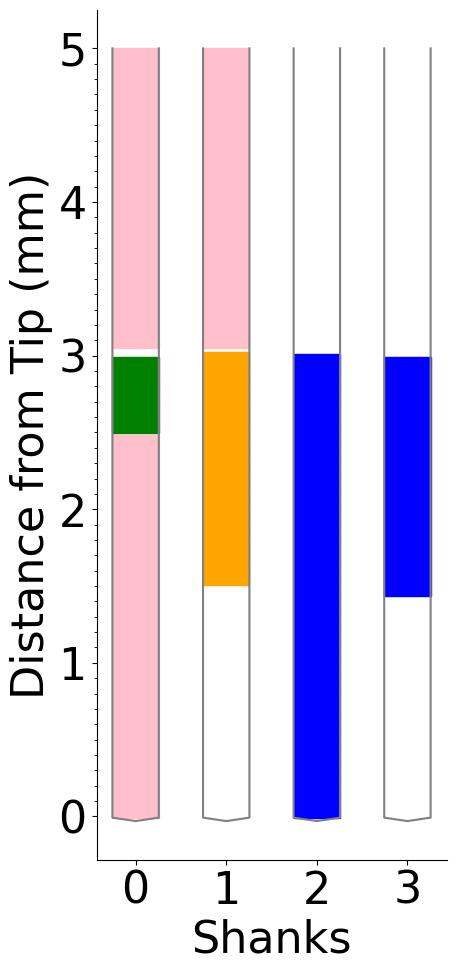

In [6]:
# blueprint

with plt.rc_context(rc):
    fg, ax = plt.subplots()

    height = 5
    plot.plot_policy_area(ax, C.probe_type, Q, height=height, shank_width_scale=2)
    plot.plot_probe_shape(ax, C.probe_type, height=height, color='gray', label_axis=True, shank_width_scale=2)


plt.show()

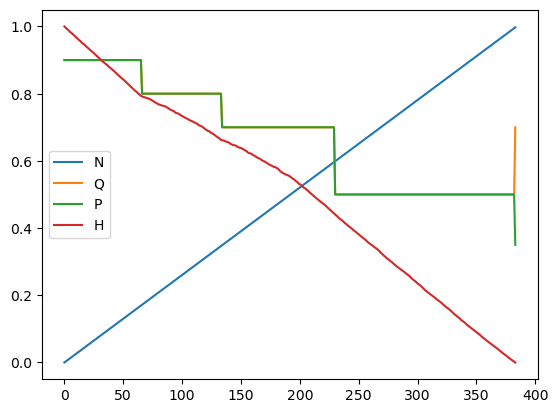

In [16]:
from chmap.probe_npx.select_weaker_debug import electrode_select
# select_weaker_debug inject debugging function into origin selecting method.
# so we can visualize the process

R = electrode_select(D, C, Q)
# shows measured value during the selection process
plt.show()
# N: number of selected electrodes / total channels
# Q: selected electrode's initial priority value
# P: selected electrode's actual priority value
# H: normalized information entropy value

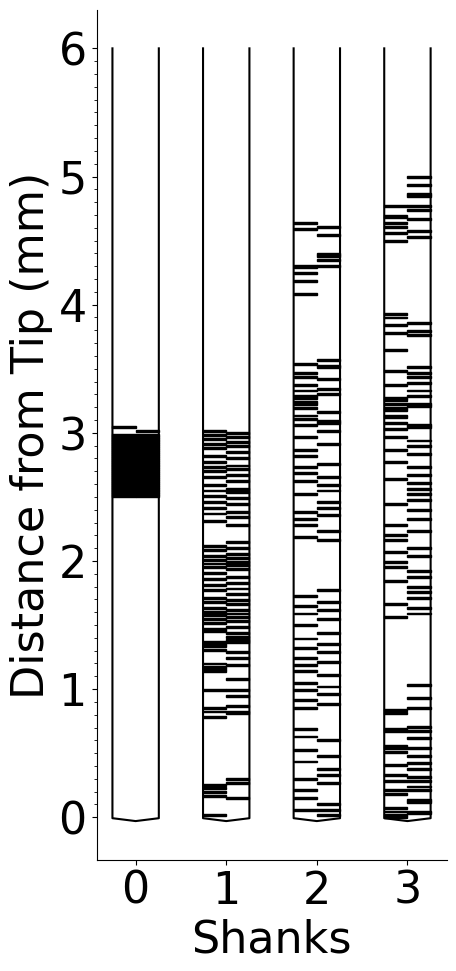

In [18]:
with plt.rc_context(rc):
    fg, ax = plt.subplots()
    plot.plot_channelmap_block(ax, R, height=6, color='k', shank_width_scale=2)
    plot.plot_probe_shape(ax, R, height=6, color='k', label_axis=True, shank_width_scale=2)

plt.show()